# Advanced Sports Analysis with GPT-4V and Crop Blending

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Dec 12 00:00:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install `ultralytics` and `supervision`

In [3]:
!pip install -q ultralytics supervision gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.4/660.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 10.5 MB/s eta 0:00:00


## Download sample video

In [4]:
!gdown '1k_vKe3fiH1uZL6u9wvE3kpgz_jOIgx4A'

Downloading...
From: https://drive.google.com/uc?id=1k_vKe3fiH1uZL6u9wvE3kpgz_jOIgx4A
To: /content/08fd33_4.mp4
100% 20.3M/20.3M [00:00<00:00, 164MB/s]


In [5]:
VIDEO_PATH = os.path.join(HOME, "08fd33_4.mp4")

## Imports

In [6]:
import cv2
import math
import json
import copy
import base64
import requests

import numpy as np
import supervision as sv

from tqdm.notebook import tqdm
from ultralytics import YOLO
from typing import List, Optional, Dict, Iterator, Tuple

## Helper functions

In [7]:
COLOR_HEX_LIST = [
    "#EE4B2B",
    "#FFFF00",
    "#D3D3D3"
]


def annotate_prompt(
    image: np.ndarray,
    detections: sv.Detections,
    labels: Optional[List[str]] = None
) -> np.ndarray:
    """
    Annotates an image with bounding boxes and labels based on provided detections.

    Parameters:
        image (np.ndarray): The image to be annotated. It should be in a format compatible with sv.BoundingBoxAnnotator
            and sv.LabelAnnotator, typically a NumPy array.
        detections (sv.Detections): A collection of detections, each typically containing information like
            bounding box coordinates, class IDs, etc., to be used for annotation.
        labels (Optional[List[str]]): A list of strings representing the labels for each detection. If not
            provided, labels are automatically generated as sequential numbers.

    Returns:
        np.ndarray: An annotated version of the input image, with bounding boxes and labels drawn over it.

    """
    bounding_box_annotator = sv.BoundingBoxAnnotator(
        color=sv.Color.black(),
        color_lookup=sv.ColorLookup.CLASS)
    label_annotator = sv.LabelAnnotator(
        color=sv.Color.black(),
        text_color=sv.Color.white(),
        color_lookup=sv.ColorLookup.CLASS,
        text_scale=0.7)

    if labels is None:
        labels = [str(i) for i in range(len(detections))]

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(
        annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(
        annotated_image, detections=detections, labels=labels)

    return annotated_image


def annotate_result(
    image: np.ndarray,
    detections: sv.Detections
) -> np.ndarray:
    """
    Annotates a given image with ellipses around detected objects.

    Parameters:
        image (np.ndarray): The image to be annotated. It should be in the format
            acceptable by sv.EllipseAnnotator.
        detections (sv.Detections): An object of sv.Detections, which contains
            the detected objects' information to be annotated on the image.

    Returns:
        np.ndarray: An image (numpy array) with ellipses drawn around the detected
            objects. This image is a modified copy of the input image.
    """
    h, w, _ = image.shape
    text_scale = sv.calculate_dynamic_text_scale(resolution_wh=(w, h))
    text_scale = min(text_scale, 0.8)
    line_thickness = sv.calculate_dynamic_line_thickness(resolution_wh=(w, h))
    ellipse_annotator = sv.EllipseAnnotator(
        color=sv.ColorPalette.from_hex(color_hex_list=COLOR_HEX_LIST),
        color_lookup=sv.ColorLookup.CLASS,
        thickness=line_thickness)
    label_annotator = sv.LabelAnnotator(
        color=sv.ColorPalette.from_hex(color_hex_list=COLOR_HEX_LIST),
        text_color=sv.Color.black(),
        color_lookup=sv.ColorLookup.CLASS,
        text_position=sv.Position.BOTTOM_CENTER,
        text_scale=text_scale)

    labels = [f"#{tracker_id}" for tracker_id in detections.tracker_id]

    annotated_image = image.copy()
    annotated_image = ellipse_annotator.annotate(
        annotated_image, detections)
    annotated_image = label_annotator.annotate(
        annotated_image, detections, labels=labels)
    return annotated_image

In [8]:
OPENAI_API_URL = "https://api.openai.com/v1/chat/completions"


def encode_image_to_base64(image: np.ndarray) -> str:
    success, buffer = cv2.imencode('.jpg', image)
    if not success:
        raise ValueError("Could not encode image to JPEG format.")

    encoded_image = base64.b64encode(buffer).decode('utf-8')
    return encoded_image


def compose_payload(images: np.ndarray, prompt: str) -> dict:
    text_content = {
        "type": "text",
        "text": prompt
    }
    image_content = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encode_image_to_base64(image=image)}"
            }
        }
        for image
        in images
    ]
    return {
        "model": "gpt-4-vision-preview",
        "messages": [
            {
                "role": "user",
                "content": [text_content] + image_content
            }
        ],
        "max_tokens": 300
    }


def compose_headers(api_key: str) -> dict:
    return {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }


def prompt_image(api_key: str, images: np.ndarray, prompt: str) -> str:
    headers = compose_headers(api_key=api_key)
    payload = compose_payload(images=images, prompt=prompt)
    response = requests.post(url=OPENAI_API_URL, headers=headers, json=payload).json()

    if 'error' in response:
        raise ValueError(response['error']['message'])
    return response['choices'][0]['message']['content']

In [9]:
def resize_images(images: List[np.ndarray], size: Tuple[int, int]) -> List[np.ndarray]:
    """
    Resizes all images to the specified size.

    Args:
        images (List[np.ndarray]): A list of images to be resized. Each image is a 3D NumPy array.
        size (Tuple[int, int]): The target size for the images, specified as (width, height).

    Returns:
        List[np.ndarray]: A list of resized images.
    """
    return [cv2.resize(image, size) for image in images]


def blend_images(images: List[np.ndarray]) -> np.ndarray:
    """
    Blends a list of images into a single image.

    Args:
    images: A list of images where each image is a NumPy array. All images must have the same shape and dtype.

    Returns:
    A blended image as a NumPy array.

    Raises:
    ValueError: If the input list is empty.
    """
    if not images:
        raise ValueError("The list of images is empty.")

    image_stack = np.stack(images)
    blended_image = np.mean(image_stack, axis=0)

    return blended_image.astype(np.uint8)


def chunk_list(lst: List, n: int) -> Iterator[List]:
    """
    Yield successive n-sized chunks from a list.

    Parameters:
        lst (List): The list to be chunked.
        n (int): The size of each chunk.

    Yields:
        Iterator[List]: An iterator over the chunks of the list, each being a list of maximum `n` elements.
    """
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

## Set OpenAI API key

In [10]:
OPENAI_API_KEY = "..."

## Load detection model

In [11]:
model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:00<00:00, 317MB/s]


## Extract single frame from sample video

In [12]:
sv.VideoInfo.from_video_path(VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=25, total_frames=750)

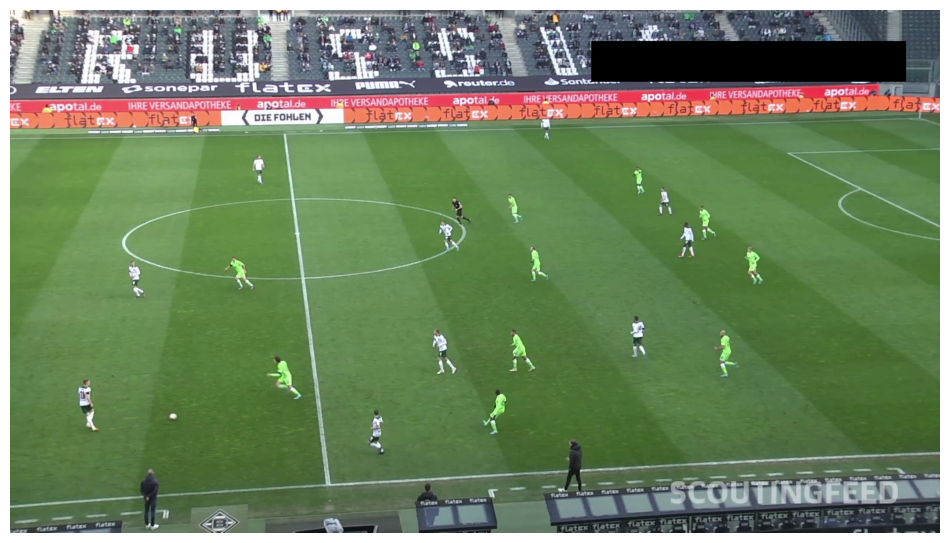

In [13]:
frame_generator = sv.get_video_frames_generator(VIDEO_PATH, start=75)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)
sv.plot_image(frame)

## Team identification

In [14]:
prompt = (
    "What colors of uniforms are worn by the teams playing in this match? "
    "Return the result in the form of a python list: [<team_uniform_color>, <team_uniform_color>]. "
    "Replace the values in `<>` with the names of the colors."
    "notalk;justgo"
)
response = prompt_image(api_key=OPENAI_API_KEY, images=[frame], prompt=prompt)
print(response)

["white", "neon green"]


In [15]:
CLASSES = json.loads(response) + ["none"]

## Baseline object detection with YOLO

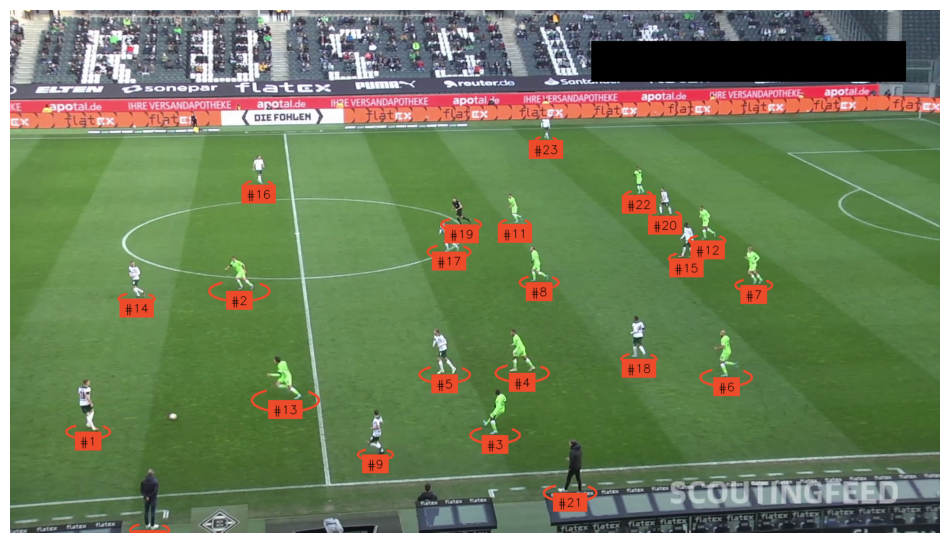

In [16]:
byte_track = sv.ByteTrack()

result = model(frame, imgsz=1280, verbose=False, iou=0.5, conf=0.3)[0]

detections = sv.Detections.from_ultralytics(result)
detections = detections[detections.class_id == 0]
detections = byte_track.update_with_detections(detections=detections)

annotated_frame = annotate_result(image=frame, detections=detections)
sv.plot_image(annotated_frame)

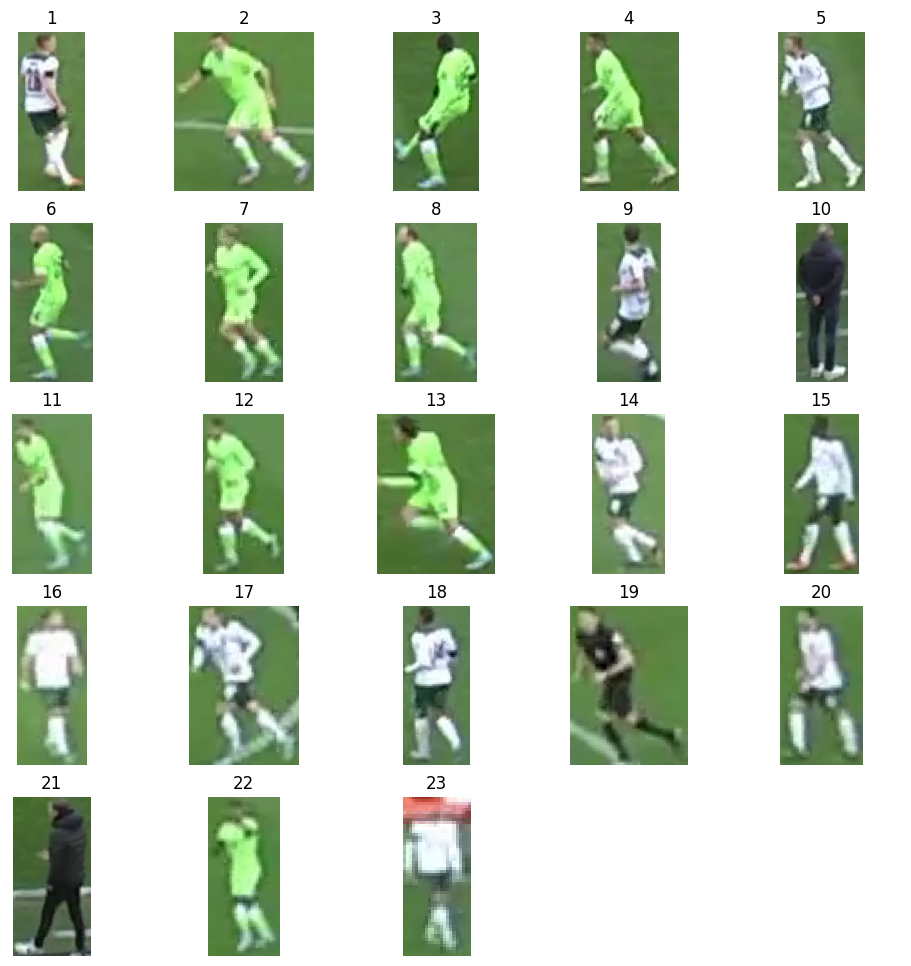

In [17]:
tracker_ids = []
crops = []

for xyxy, _, confidence, class_id, tracker_id in detections:
    crop = sv.crop_image(frame, xyxy)
    crops.append(crop)
    tracker_ids.append(tracker_id)

sv.plot_images_grid(crops, titles=[str(tracker_id) for tracker_id in tracker_ids], grid_size=(5, 5))

## Team assignment based on blended crops

In [16]:
byte_track = sv.ByteTrack()
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(VIDEO_PATH, start=0, end=25*10)

frames_buffer = []
detections_buffer = []
crops_buffer = {}

for frame in tqdm(frame_generator, total=video_info.total_frames):
    result = model(frame, imgsz=1280, verbose=False, iou=0.5, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)
    detections = detections[detections.class_id == 0]
    detections = byte_track.update_with_detections(detections=detections)

    frames_buffer.append(frame)
    detections_buffer.append(detections)

    for xyxy, _, confidence, class_id, tracker_id in detections:
        crop = sv.crop_image(frame, xyxy)
        if crop.size != 0:
            crops_buffer.setdefault(tracker_id, []).append(crop)

tracker_ids = []
blended_crops = []
for tracker_id, crops in crops_buffer.items():
    resized_crops = resize_images(crops, (200, 200))
    blended_crop = blend_images(resized_crops)
    tracker_ids.append(tracker_id)
    blended_crops.append(blended_crop)

  0%|          | 0/750 [00:00<?, ?it/s]

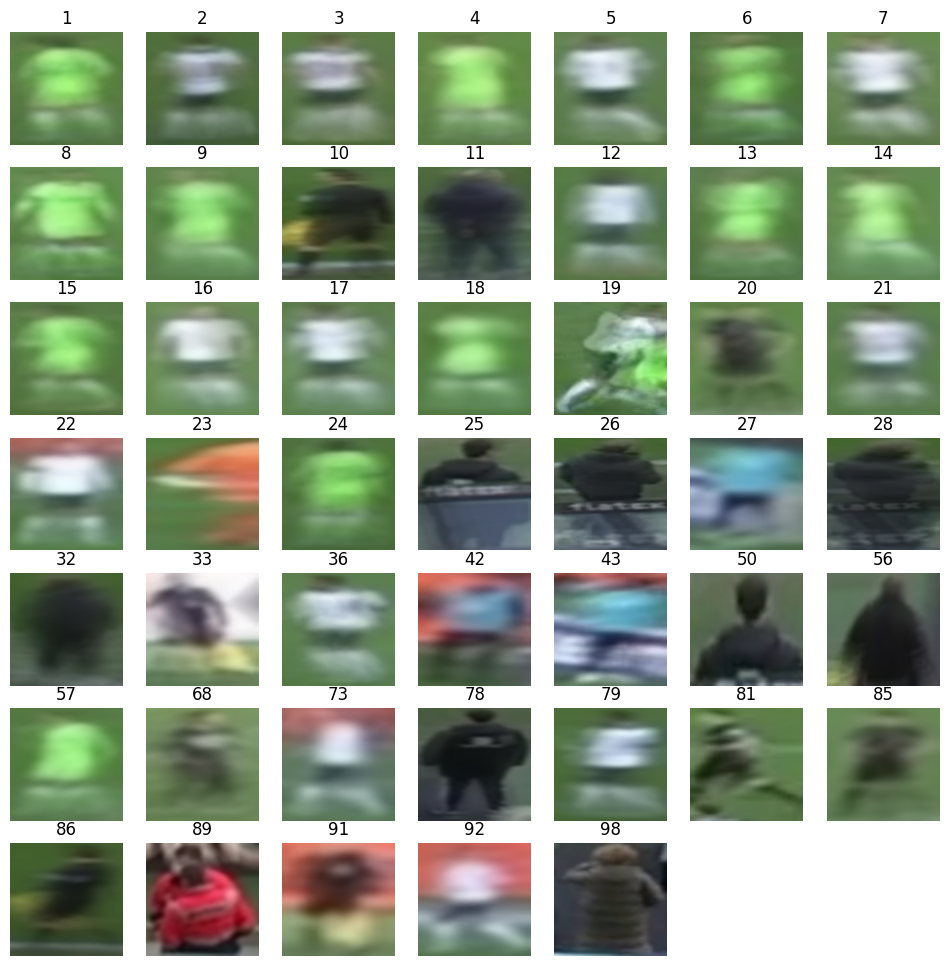

In [17]:
N = math.ceil(math.sqrt(len(blended_crops)))
sv.plot_images_grid(
    blended_crops,
    titles=[str(tracker_id) for tracker_id in tracker_ids],
    grid_size=(N, N)
)

## Prompt GPT-4 Vision

In [19]:
PROMPT = (
    "Identify the team of the marked individual in the composite image: "
    "These images are composite and may not have a distinct human shape. "
    "However, since the color information in the images approximates the color of the person's uniform, "
    "team information is determined from these color information. "
    "The `options are `white` or `neon green`. If the individual in the marked composite image does not belong to either team. "
    "(e.g., is a referee, coach, or fan), return `none`. Referees are distinguishable by their black uniforms. "
    "If it is very difficult to determine the classification, please classify based on the color information near the center as much as possible "
    "Coaches and fans should not be considered as team members. "
    "Provide the results in JSON format. The output should include key-value pairs, each representing a bounding box. "
    "Format the output like this: {'0': 'color_1', '1': 'color_2', ...}, "
    "where 'color_1', 'color_2', ... are to be replaced with 'white', 'neon green', or 'none', as applicable. "
    "Use double quotes to enclose property names. "
    "IMPORTANTLY, do not surround the result with punctuation marks (`). "
    "notalk;justgo"
)

batch_size = 5
crop_batches = list(chunk_list(blended_crops, batch_size))
merged_response = {}

for i, batch in tqdm(enumerate(crop_batches)):
    start_index = i * batch_size
    response = prompt_image(api_key=OPENAI_API_KEY, images=batch, prompt=PROMPT)
    try:
        response_dict = json.loads(response)
        for key, value in response_dict.items():
            merged_response[str(int(key) + start_index)] = value
    except json.JSONDecodeError:
        print(f"Invalid JSON received as response: {response}")

0it [00:00, ?it/s]

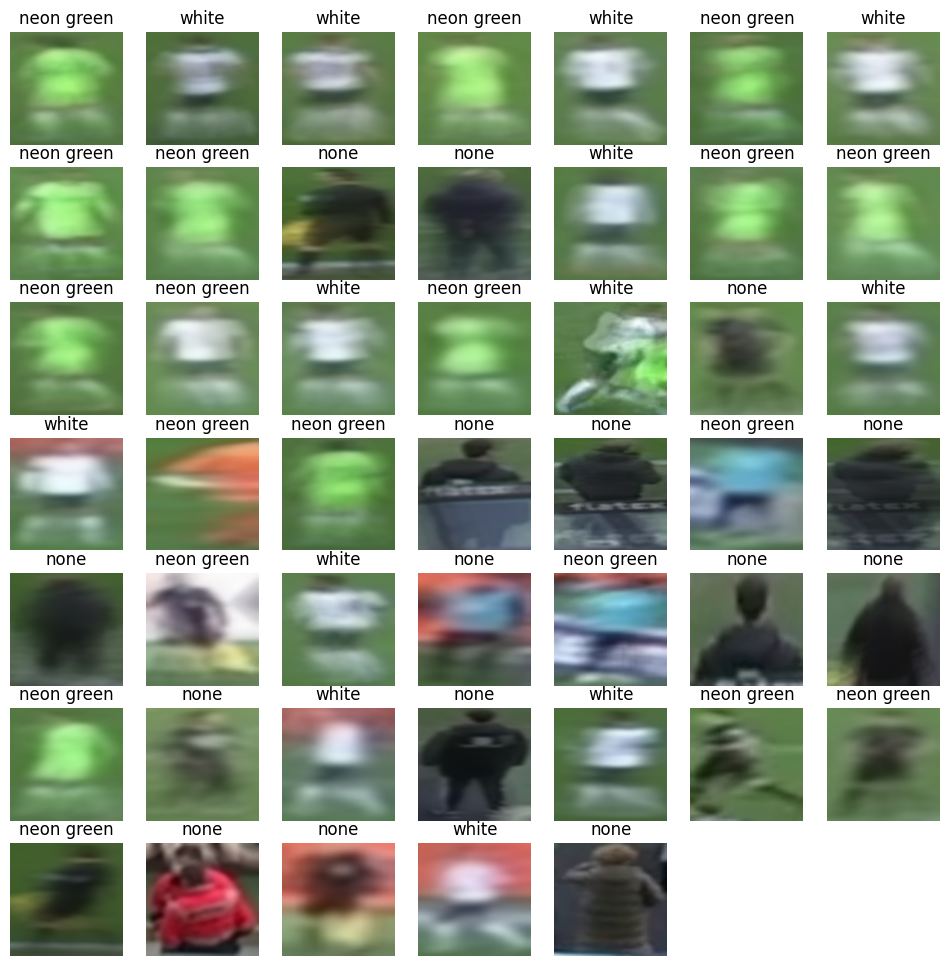

In [20]:
N = math.ceil(math.sqrt(len(blended_crops)))
sv.plot_images_grid(blended_crops, titles=list(merged_response.values()), grid_size=(N, N))

In [21]:
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)

with sv.VideoSink(target_path='raw-tracking.mp4', video_info=video_info) as sink:
    for frame, detections in zip(frames_buffer, detections_buffer):
        annotated_frame = annotate_result(image=frame, detections=detections)
        sink.write_frame(frame=annotated_frame)

In [22]:
mapping_dict = {
    tracker_ids[int(index)]: CLASSES.index(class_name)
    for index, class_name
    in merged_response.items()
}

vectorized_map = np.vectorize(lambda x: mapping_dict.get(x, -1))

In [23]:
for detections in detections_buffer:
    detections.class_id = vectorized_map(detections.tracker_id)

In [24]:
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)

with sv.VideoSink(target_path='result.mp4', video_info=video_info) as sink:
    for frame, detections in zip(frames_buffer, detections_buffer):
        annotated_frame = annotate_result(image=frame, detections=detections)
        sink.write_frame(frame=annotated_frame)